In [1]:
# dependencies import
from common_dependencies import *
logger = logging.getLogger(f'main.ae_model_train')

2024-05-01 22:32:42.907478: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2024-05-01 22:32:42.945484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 22:32:43.318295: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN


In [2]:
# train params that can be easily changed
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)
MAX_VAL = 1000
XSHIFT = 200
dataset_desc = {'train': (DatasetPartDescription(PATH_TO_DATA['run_1'],DataCrop(120,0,240,MAX_VAL),SlidingCrop(1,1),XSHIFT),),
                'val': (DatasetPartDescription(PATH_TO_DATA['run_1'],DataCrop(0,0,120,MAX_VAL),SlidingCrop(1,1),XSHIFT),
                        DatasetPartDescription(PATH_TO_DATA['run_1'],DataCrop(360,0,MAX_VAL,MAX_VAL),SlidingCrop(1,1),XSHIFT),
                        DatasetPartDescription(PATH_TO_DATA['run_2'],DataCrop(0,0,MAX_VAL,40),SlidingCrop(1,1),XSHIFT)),
                'test': (DatasetPartDescription(PATH_TO_DATA['run_2'],DataCrop(0,40,MAX_VAL,MAX_VAL),SlidingCrop(1,1),XSHIFT),)}

In [3]:
#входные и выходные данные
# reading
dataset = {'train':dict(zip(['x','y','bin'], [np.array(list(gen)) for gen in chain_dataset_gens(dataset_desc['train'])])),
           'val':dict(zip(['x','y','bin'], [np.array(list(gen)) for gen in chain_dataset_gens(dataset_desc['val'])])), 
           'test':dict(zip(['x','y','bin'], [np.array(list(gen)) for gen in chain_dataset_gens(dataset_desc['test'])]))}

# squueze datasets
for dataset_part_name, dataset_part in dataset.items():
    for data_part_name, data_part in dataset_part.items():
        if data_part_name == 'x':
            dataset[dataset_part_name][data_part_name] = data_part.reshape(-1,64)
        if data_part_name == 'y':
            dataset[dataset_part_name][data_part_name] = data_part.reshape(-1)

# displaying
logger.debug('Dataset')
for dataset_part_name, dataset_part in dataset.items():
    logger.debug('|'*8+dataset_part_name+'|'*8)
    for data_part_name, data_part in dataset_part.items():
        logger.debug(f'{data_part_name}.shape: {data_part.shape}, max={np.max(data_part)}, min={np.min(data_part)}')

main ::      get_dataset_gen() :: start
main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (115, 400)
    Read defect data shape: (115, 400)
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 44.5
    The arr min before normalization: 0.0
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 62.992
    The arr min before normalization: -61.968
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 4.5
    The arr min before normalization: 0.0
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker._ndarray_utils :: extend_ndarray_for_crops_di

main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (115, 400)
    Read defect data shape: (115, 400)


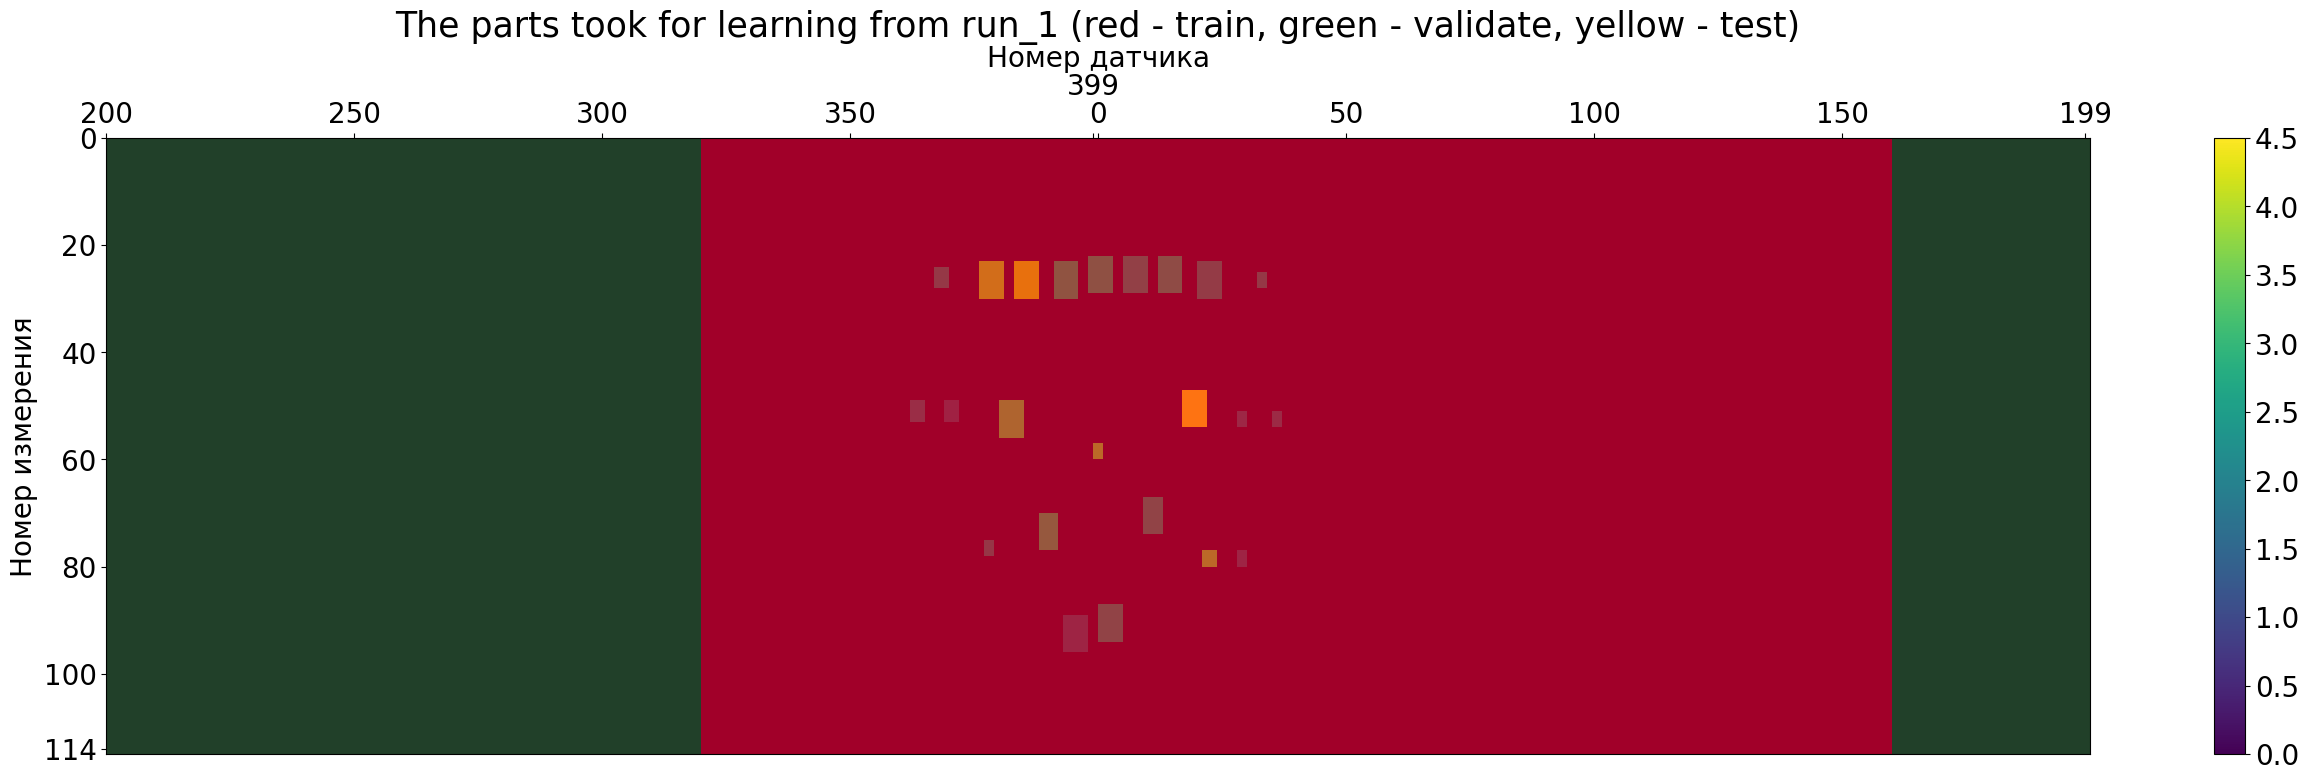

main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (119, 400)
    Read defect data shape: (119, 400)


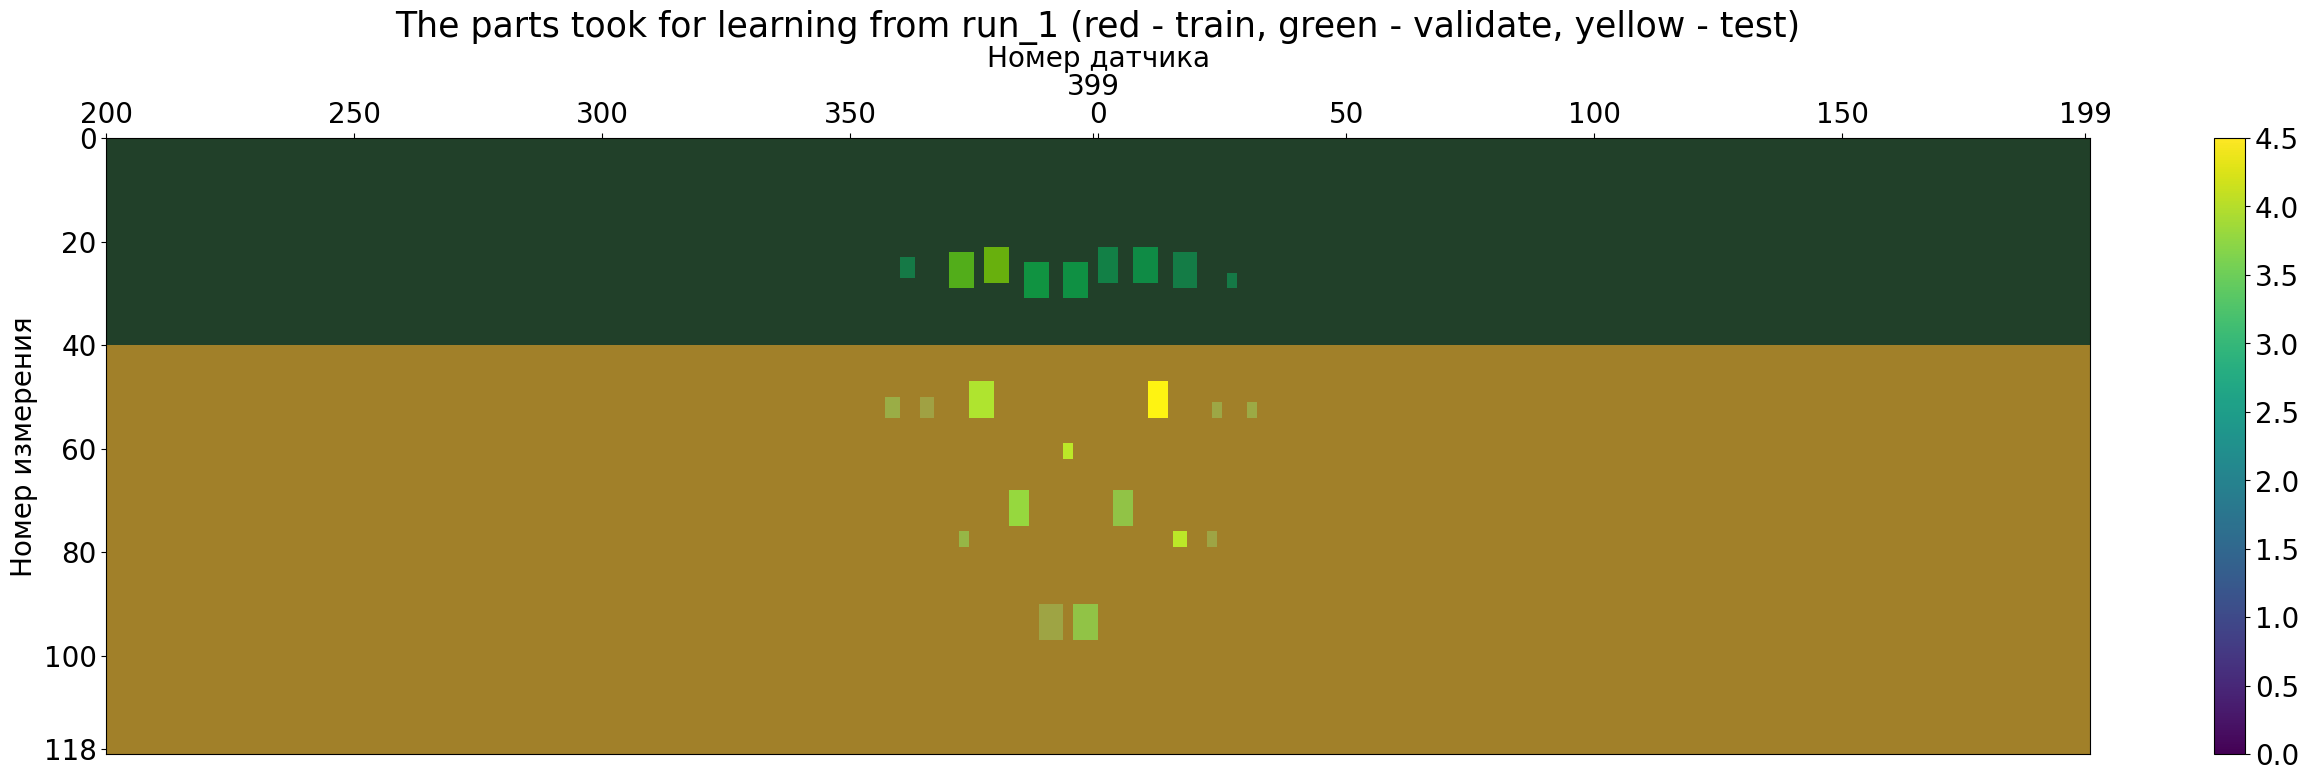

In [4]:
#выборка данных
# show parts took for learning
all_rects = {'run_1': {'train':None,'val':None,'test':None}, 
             'run_2': {'train':None,'val':None,'test':None}}
rects_colors = {'train':'red', 'val':'green', 'test':'yellow'}

for run_name in all_rects.keys():
    x_df, y_df = dw.get_x_and_y_data(*PATH_TO_DATA[run_name])
    x_df = None
    y_df = dw.roll_df(y_df, XSHIFT, 1)
    for dataset_part_name in all_rects[run_name].keys():
        # get all DatasetPartDescription for train, val or test
        dataset_part_desc = dataset_desc[dataset_part_name]
        # get all DatasetPartDescription for current run_name (run_1 or run_2)
        dataset_part_desc = [dataset_part for dataset_part in dataset_part_desc if re.findall(r'run_\d', dataset_part.data_path_tuple[0])[0] == run_name]
        # put rects list to all_rects[run_name][dataset_part_name]
        all_rects[run_name][dataset_part_name] = [Rectangle((dataset_part.file_data_crop.left, dataset_part.file_data_crop.top), 
                           dataset_part.file_data_crop.width, dataset_part.file_data_crop.height, 
                           facecolor=rects_colors[dataset_part_name], alpha=0.5) for dataset_part in dataset_part_desc]
    res_rects = list(itertools.chain(*[run_rects for run_rects_name, run_rects in all_rects[run_name].items()]))
    if res_rects:
        dw.draw_defects_map_with_rectangles_owerlap(y_df, res_rects, title = f'The parts took for learning from run_1 (red - train, green - validate, yellow - test)')

In [35]:
#### всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.0002 #0.0000002 # шаг сходимости back propogation
CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
#CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_funcs = keras.losses.MeanSquaredError() #BinaryCrossentropy() 
#CMP_metrics = [keras.metrics.MeanSquaredError(name='MeanSquaredError')]
#///////////////////////////////// для колбэков

# для Early_stopping
ES_patience = 6 # кол-во эпох без улучшений
ES_min_delta = 0.0001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'val_loss' # отслеживаемый параметр 
ES_save_best_weights = False # сохранять ли веса нейронки с лучшими результатами
#Es_mode = 'max'

   # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'loss'  # отслеживаемый параметр 
RLPOP_factor = 0.3 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 1 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 2 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 4 # размерpython concat lists bach при обучении/тестировании1
#FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 30 # количество эпох обучения
#FIT_validation_split = 0.10 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

In [36]:
#шараш-монтаж модели сети
enc_input = layers.Input((64,), name='enc_input')
d = layers.Dense(64, activation='linear')(enc_input)
d = layers.Dense(32, activation='linear')(d)
d = layers.Dense(16, activation='linear')(d)
d = layers.Dense(8, activation='linear')(d)
d = layers.Dense(4, activation='linear')(d)
hidden_state_output = layers.Dense(2, activation='linear', name='hidden_state_output')(d)
d = layers.Dense(4, activation='linear')(hidden_state_output)
d = layers.Dense(8, activation='linear')(d)
d = layers.Dense(16, activation='linear')(d)
d = layers.Dense(32, activation='linear')(d)
dec_output = layers.Dense(64, activation='sigmoid', name='dec_output')(d)

ae = keras.Model(enc_input, dec_output, name='vae')
ae.compile(optimizer=CMP_solver, loss=CMP_loss_funcs)

print(ae.summary())

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_input (InputLayer)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_state_output (Dense)     │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_output (Dense)              │ (None, 64)             │         2,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,802 (38.29 KB)

 Trainable params: 9,802 (38.29 KB)

 Non-trainable params: 0 (0.00 B)

None


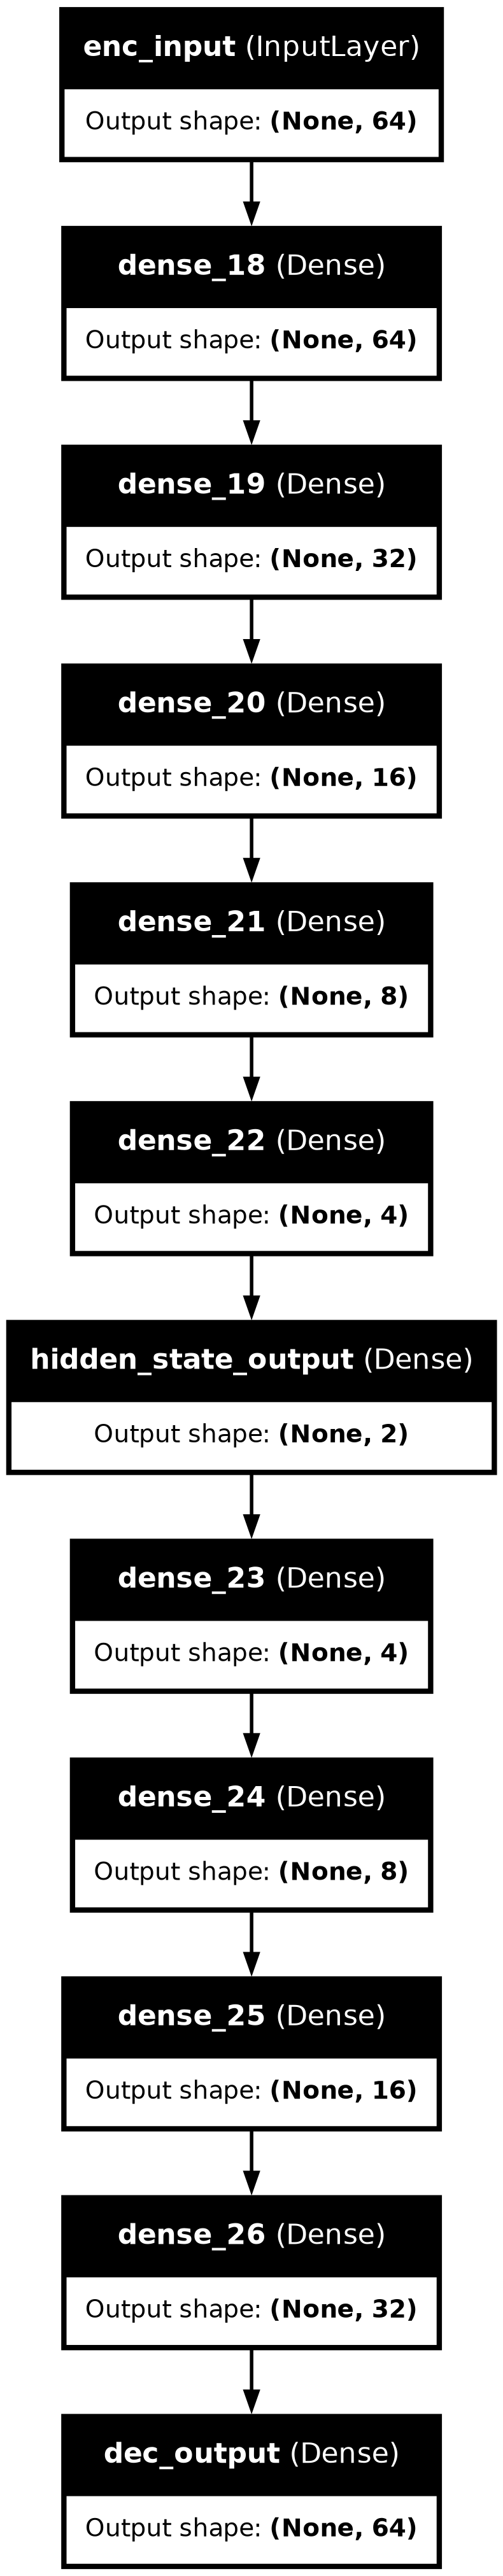

In [37]:
#визуализация сети в виде графа
tf.keras.utils.plot_model(
    ae,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

In [38]:

# Создание и настройка колбэков

callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = ae## тут был model
            )

In [39]:
history = ae.fit(dataset['train']['x'], dataset['train']['x'],
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    shuffle=True,
                    validation_data = (dataset['val']['x'], dataset['val']['x']), 
                    callbacks = FIT_callback_list)

6900/6900 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0378 - val_loss: 0.0277 - learning_rate: 2.0000e-04
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0264 - val_loss: 0.0276 - learning_rate: 2.0000e-04
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0263
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0263 - val_loss: 0.0274 - learning_rate: 2.0000e-04
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0260 - val_loss: 0.0273 - learning_rate: 6.0000e-05
6883/6900 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0260
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.7999999545281754e-05.
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0260 - val_loss: 0.0273 - learning_rate: 6.0000e-05
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0260 - val_loss: 0.0272 - learning_rate: 1.8000e-05
6869/6900 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0259
Epoch 7: ReduceLROnPlateau reducing l

In [41]:
res_loss = ae.evaluate(dataset['test']['x'], dataset['test']['x'], batch_size = 32)

988/988 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step


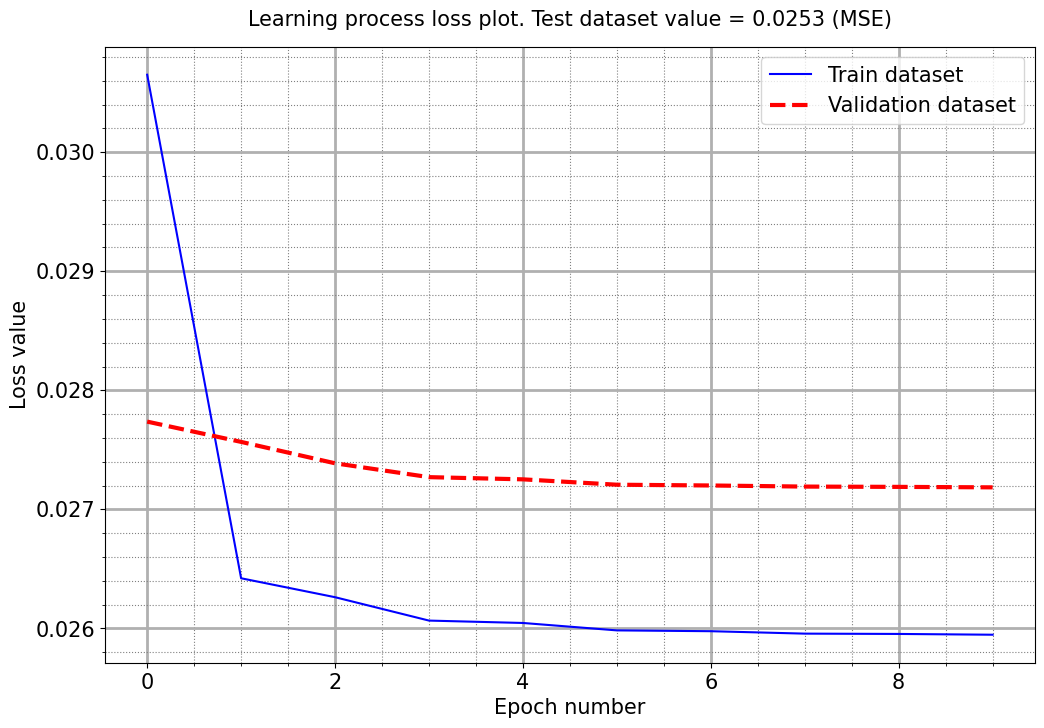

In [43]:
FONT_SIZE = 15
fig, ax = plt.subplots()

fig.set_figwidth(12)
fig.set_figheight(8)

ax.plot(history.history['loss'], 
         label='Train dataset',  linewidth=1.5, color='blue')
ax.plot(history.history[f'val_loss'], linestyle = '--', 
     label='Validation dataset',  linewidth=3, color='red')
ax.set_xlabel('Epoch number', fontsize=FONT_SIZE)
ax.set_ylabel(f'Loss value', fontsize=FONT_SIZE)
ax.set_title(f"Learning process loss plot. Test dataset value = {res_loss:.4f} (MSE)", fontsize=FONT_SIZE, pad=15)

ax.patch.set_alpha(0)

#  Устанавливаем форматирование делений:
ax.tick_params(axis='both', which='both', labelsize = FONT_SIZE)

# Вывод и настройка сетки
ax.minorticks_on()
ax.grid(which='major', linewidth=2)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')

plt.show()

In [29]:
# сохранение модели в файл
#import h5py
#from tensorflow.keras.models import load_model
#ae.save(f"networks/AE/id=v04n01_loss(train={history.history['loss'][-1]:.4f},val={history.history['val_loss'][-1]:.4f},test={res['loss']:.4f}).keras")